# 캐글 노트북 참조해보기
[Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

# Features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
cats = pd.read_csv('./data/item_categories.csv')
train = pd.read_csv('./data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./data/test.csv').set_index('ID')

In [3]:
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [4]:
print(cats)

                          item_category_name  item_category_id
0                    PC - Гарнитуры/Наушники                 0
1                           Аксессуары - PS2                 1
2                           Аксессуары - PS3                 2
3                           Аксессуары - PS4                 3
4                           Аксессуары - PSP                 4
5                        Аксессуары - PSVita                 5
6                      Аксессуары - XBOX 360                 6
7                      Аксессуары - XBOX ONE                 7
8                             Билеты (Цифра)                 8
9                            Доставка товара                 9
10                     Игровые консоли - PS2                10
11                     Игровые консоли - PS3                11
12                     Игровые консоли - PS4                12
13                     Игровые консоли - PSP                13
14                  Игровые консоли - PSVita           

## Outliers
price > 100,000 and sales > 1001 인 아이템을 떨궈버리고 했다고 함.
아래에 분포를 그려보니 이해가 됨.

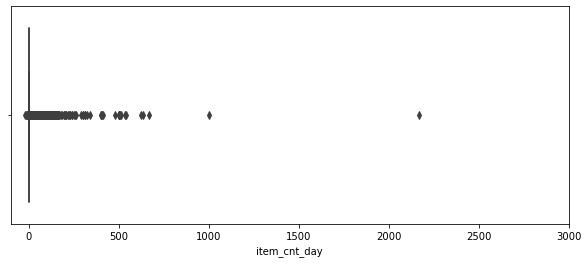

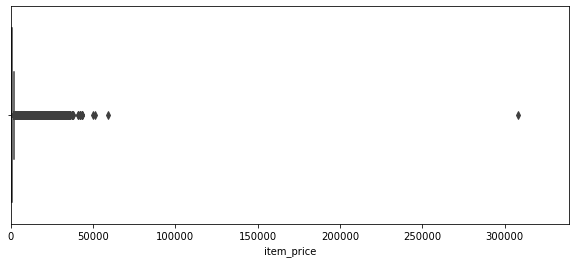

In [5]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [6]:
# 떨궈내기
ITEM_PRICE_LIM = 100000
ITEM_CNT_LIM = 1001
train = train[train.item_price<ITEM_PRICE_LIM]
train = train[train.item_cnt_day<ITEM_CNT_LIM]

가격이 0 미만인 아이템이 있어서 median으로 채웠다고함.

In [7]:
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [8]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


가게 이름 겹치는 경우 제거했다고 함. 

In [9]:
# Якутск Орджоникидзе, 56 => shop_id 0, 57
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный" => shop_id 1,58
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м² => shop_id 10,11
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
1. 각 가게 이름이 도시 이름으로 시작한다고 함
2. 각 카테고리 이름 안에 type 과 sub_type이 있다고 함.

In [10]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
# item_category_name 에서 type 꺼내서 따로
cats['type'] = cats['split'].map(lambda x: x[0].strip())
# 따로 꺼낸 type 을 type_code 컬럼에 인코딩한 값 넣기
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

### Monthly Sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past.   

**The main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.**

In [11]:
# 363 items are new compared to the train.
print(len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))))
# 5100 items
print(len(list(set(test.item_id))))
# 214200 pairs.
print(len(test))

363
5100
214200


In [12]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
NUM_MONTHS = 34
for i in range(NUM_MONTHS):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
print(matrix)    
# matrix 행으로 쌓은 dataframe 만들기
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
print('=====================================')
print(matrix)
matrix.sort_values(cols,inplace=True)
time.time() - ts

[array([[    0,    59, 22154],
       [    0,    59,  2552],
       [    0,    59,  2554],
       ...,
       [    0,    45,   628],
       [    0,    45,   631],
       [    0,    45,   621]], dtype=int16), array([[    1,    50,  3880],
       [    1,    50,  4128],
       [    1,    50,  4124],
       ...,
       [    1,    28, 12885],
       [    1,    28, 12791],
       [    1,    28, 13433]], dtype=int16), array([[    2,     5, 20175],
       [    2,     5, 20083],
       [    2,     5,    31],
       ...,
       [    2,     4, 12388],
       [    2,     4, 12340],
       [    2,     4, 10649]], dtype=int16), array([[    3,    25,  8092],
       [    3,    25,  7850],
       [    3,    25,  8051],
       ...,
       [    3,    41, 14063],
       [    3,    41, 20690],
       [    3,    41, 19235]], dtype=int16), array([[    4,    59, 22114],
       [    4,    59, 20239],
       [    4,    59, 20238],
       ...,
       [    4,     6,  1924],
       [    4,     6,  1972],
       [ 

11.583051919937134

Aggregate train set by shop/item pairs to calculate target aggreagates, then **clip(0,20) target value.** This way train target will be similar to the test predictions.   

I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later.** If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.**

In [13]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [14]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts


2.9839565753936768

### Test set
To use time tricks append test pairs to the matrix.

In [15]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head(5)

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [16]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.04074692726135254

### Shops/Items/Cats features

In [17]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

2.4249141216278076

### Target lags

In [18]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [19]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

20.39374876022339

### Mean encoded features

In [20]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

26.604565382003784

In [21]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

23.174132108688354

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

24.35334539413452

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

7.651514291763306

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

7.9485626220703125

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

7.974253177642822

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.119440078735352

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.219192028045654

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

12.344514608383179

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.472869873046875

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

8.610391616821289

### Trend features
price trend for the last six months

In [31]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

270.7301206588745

Last month shop revenue trend

In [32]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
print(matrix.head(5))
time.time() - ts

   date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   
3               0        2       29             0.0          0   
4               0        2       32             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   NaN   
1                19          5            10                   NaN   
2                30          8            55                   NaN   
3                23          5            16                   NaN   
4                40         11             4                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                 

280.70893383026123

### Special features

In [33]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [34]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.

In [ ]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

In [ ]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

Months since the first sale for each shop/item pair and for item only.

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

Producing lags brings a lot of nulls.

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# xgboost

In [ ]:
data = pd.read_pickle('data.pkl')

위에서 만든 feature 들

In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set,   
33 month for the validation set and 13-33 months for the train.

In [ ]:
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
del data
gc.collect();

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
plot_features(model, (10,14))